In [1]:
from traffic.core import Traffic
training_trajectories_path = "../data/real/OpenSky_EHAM_LIMC.pkl"
training_trajectories = Traffic.from_file(training_trajectories_path)
synthetic_trajectories_path = "../data/synthetic_compare/OpenSky_EHAM_LIMC.pkl"
synthetic_trajectories = Traffic.from_file(synthetic_trajectories_path)

route_name = "EHAM_LIMC"

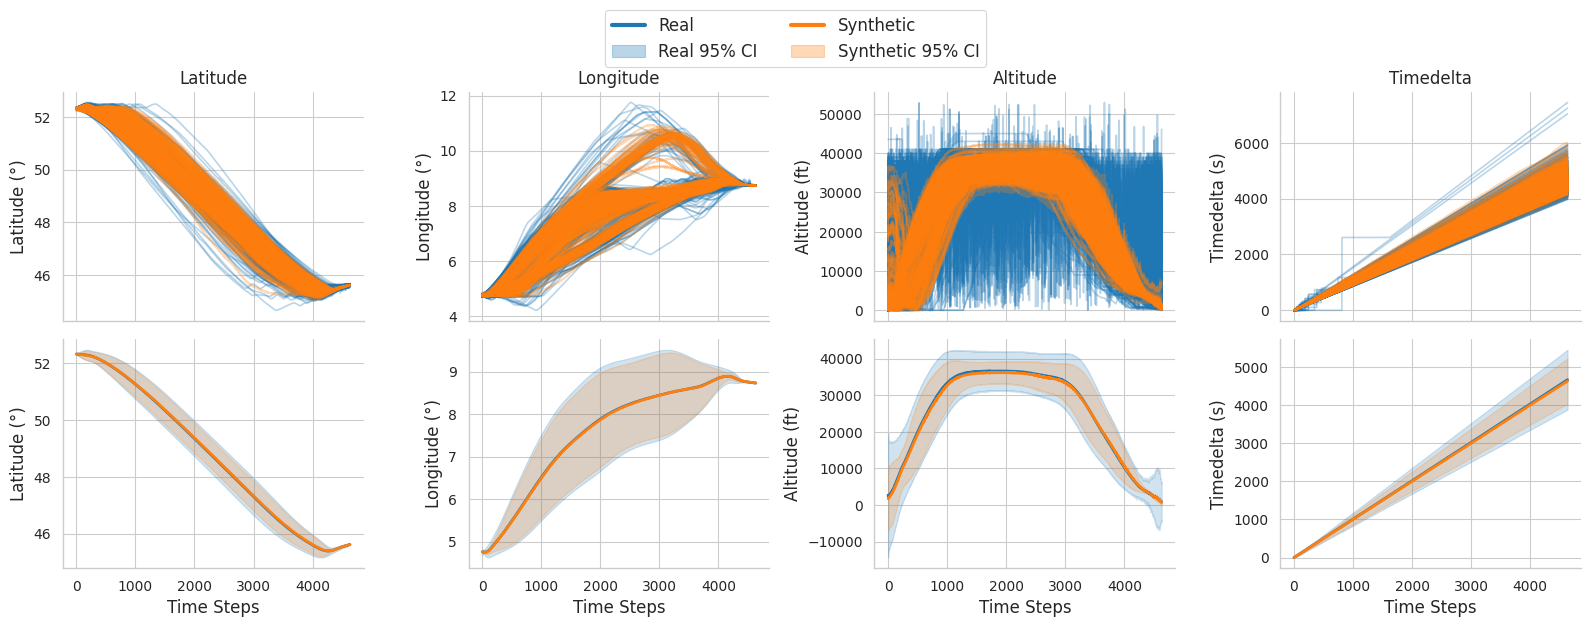

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.patches import Patch

def timeseries_plot(
    real_traffic,
    synthetic_traffic,
    features: list,
    units: dict,
    n_plot_samples: int = 1000,
    alpha: float = 0.3
):
    # Set the style for a more professional look
    sns.set(style="whitegrid")
    sns.set_context("paper")

    # Create subplots
    fig, axes = plt.subplots(2, len(features), figsize=(4 * len(features), 6), sharex=True)

    # Prepare data
    datasets = [real_traffic, synthetic_traffic]
    dataset_names = ['Real', 'Synthetic']
    colors = ['#1f77b4', '#ff7f0e']  # Specified colors

    for feature_idx, feature in enumerate(features):
        # Top row: individual trajectories
        for dataset_idx, (dataset, color) in enumerate(zip(datasets, colors)):
            feature_data = np.array([flight.data[feature].values for flight in dataset])
            sample_ind = np.random.randint(0, len(feature_data), min(n_plot_samples, len(feature_data)))
            for idx in sample_ind:
                axes[0, feature_idx].plot(feature_data[idx], alpha=alpha, color=color)

        axes[0, feature_idx].set_title(f"{feature.capitalize()}", fontsize=12)
        axes[0, feature_idx].tick_params(labelsize=10)
        axes[0, feature_idx].set_ylabel(f"{feature.capitalize()} ({units[feature]})", fontsize=12)

        # Bottom row: mean and confidence intervals
        for dataset_idx, (dataset, color) in enumerate(zip(datasets, colors)):
            feature_data = np.array([flight.data[feature].values for flight in dataset])
            mean_data = np.mean(feature_data, axis=0)
            std_data = np.std(feature_data, axis=0)

            axes[1, feature_idx].plot(mean_data, color=color, linewidth=2)

            t_value = stats.t.ppf(0.975, df=len(feature_data)-1)
            ci = t_value * std_data * np.sqrt(1 + 1/len(feature_data))
            axes[1, feature_idx].fill_between(
                range(len(mean_data)),
                mean_data - ci,
                mean_data + ci,
                color=color,
                alpha=0.2
            )

        axes[1, feature_idx].set_xlabel("Time Steps", fontsize=12)
        axes[1, feature_idx].set_ylabel(f"{feature.capitalize()} ({units[feature]})", fontsize=12)
        axes[1, feature_idx].tick_params(labelsize=10)

        # Remove top and right spines for both rows
        for row in range(2):
            axes[row, feature_idx].spines['top'].set_visible(False)
            axes[row, feature_idx].spines['right'].set_visible(False)

    # Create custom legend elements
    legend_elements = []
    for color, name in zip(colors, dataset_names):
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=3, label=f'{name}'))
        legend_elements.append(Patch(facecolor=color, edgecolor=color, alpha=alpha, label=f'{name} 95% CI'))

    # Add a single legend for the entire figure
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 1.05))

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"../.figures/timeseries_ci_{route_name}.png", bbox_inches='tight')
    plt.show()

# Usage
features_to_plot = ['latitude', 'longitude', 'altitude', 'timedelta']
units = {
    'latitude': '°',
    'longitude': '°',
    'altitude': 'ft',
    'timedelta': 's'
}

timeseries_plot(
    training_trajectories,
    synthetic_trajectories,
    features=features_to_plot,
    units=units
)